In [17]:
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(1,10,0.1)
y = 2 * X + np.random.randn(X.shape[0])

X = np.array([X, y]).T

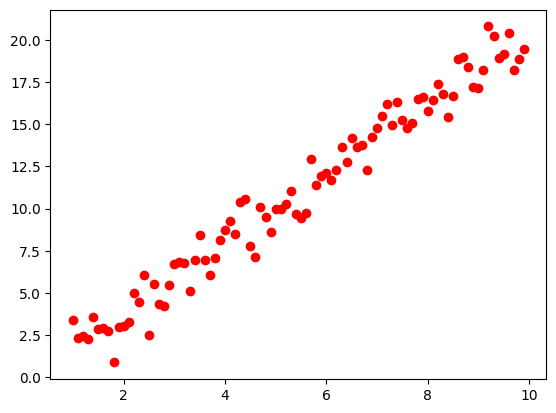

In [18]:
plt.plot(X[:,0], X[:,1], 'ro')


In [19]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [20]:
W1 = Vt.T[:,0]
X_d = X_centered.dot(W1)

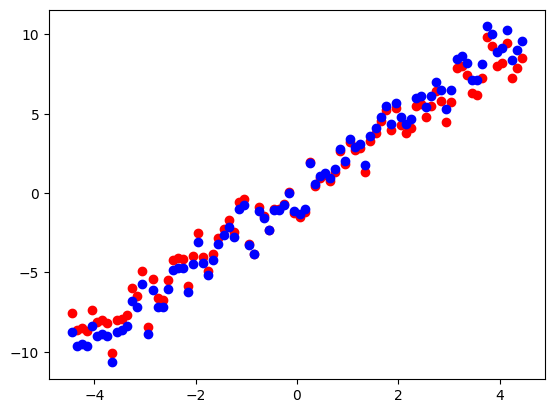

In [24]:
plt.plot(X_centered[:,0], X_centered[:,1], 'ro')
plt.plot(X_centered[:,0], X_d, 'bo')

                    使用Scikit-Learn                    

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
X2D = pca.fit_transform(X)

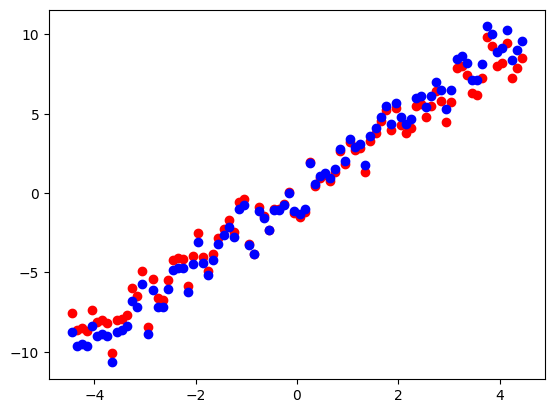

In [34]:
plt.plot(X_centered[:,0], X_centered[:,1], 'ro')
plt.plot(X_centered[:,0], -X2D, 'bo')

In [37]:
print(c1)
pca.components_

[0.42330436 0.90598754]


array([[-0.42330436, -0.90598754]])

In [38]:
# 另一个有用的信息是每个主成分的可解释方差比
# 可以通过explained_variance_ratio_变量来获得。该比率表示沿每个成分的数据集方差的比率
pca.explained_variance_ratio_

# 此输出告诉你，数据集方差的99.5%位于第一个PC上

array([0.99515945])

                    选择正确的维度                  

In [ ]:
# 与其任意选择要减小到的维度，不如选择相加足够大的方差部分（例如95%）的维度。
# 当然，如果你是为了数据可视化而降低维度，这种情况下，需要将维度降低到2或3


# 以下代码在不降低维度的情况下执行PCA，然后计算保留95%训练集方差所需的最小维度
# 然后，你可以设置n_components=d并再次运行PCA。
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

# 但是还有一个更好的选择：将n_components设置为0.0到1.0之间的浮点数来表示要保留的方差率，
# 而不是指定要保留的主成分数：

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

                    随机PCA                 

In [ ]:
# 如果将超参数svd_solver设置为"randomized"，则Scikit-Learn将使用一种称为Randomized PCA的随机算法，
# 该算法可以快速找到前d个主成分的近似值。它的计算复杂度为O（m×d2）+O（d3），
# 而不是完全SVD方法的O（m×n2）+O（n3），因此，当d远远小于n时，它比完全的SVD快得多

rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X)

# 默认情况下，svd_solver实际上设置为"auto"：如果m或n大于500并且d小于m或n的80%，
# 则Scikit-Learn自动使用随机PCA算法，否则它将使用完全的SVD方法。
# 如果要强制Scikit-Learn使用完全的SVD，可以将svd_solver超参数设置为"full"。

                    增量PCA                 

In [ ]:
# 前面的PCA实现的一个问题是，它们要求整个训练集都放入内存才能运行算法。
# 幸运的是已经开发了增量PCA（IPCA）算法，它们可以使你把训练集划分为多个小批量，
# 并一次将一个小批量送入IPCA算法。这对于大型训练集和在线（即在新实例到来时动态运行）应用PCA很有用

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X)

In [ ]:
# 另外，你可以使用NumPy的memmap类，
# 该类使你可以将存储在磁盘上的二进制文件中的大型数组当作完全是在内存中一样来操作，
# 该类仅在需要时才将数据加载到内存中。
# 由于IncrementalPCA类在任何给定时间仅使用数组的一小部分，
# 因此内存使用情况处于受控状态。如以下代码所示，这使得调用通常的fit（）方法成为可能：


# X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
# batch_size = m // n_batches
# inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
# inc_pca.fit(X_mm)